## Probability Calibration

[Machine Learning with Imbalanced Data - Course](https://www.trainindata.com/p/machine-learning-with-imbalanced-data)

In this notebook, we will re-calibrate probabilities utilizing a toy dataset for the demo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# toy data
from sklearn.datasets import make_classification

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

import warnings
warnings.filterwarnings("ignore")

## Create balanced dataset

In [2]:
def create_dataset(weights):

    # returns arrays
    X, y = make_classification(
        n_samples=100000,
        n_features=20,
        n_informative=2,
        n_redundant=10,
        n_clusters_per_class=1,
        weights=[weights],  # to balance (or not) the classes
        class_sep= 0.8,  # how separated the classes are
        random_state=42)
            
    # trasform arrays into pandas df and series
    X = pd.DataFrame(X)
    y = pd.Series(y)

    return X, y

X, y = create_dataset(weights=0.5)

In [3]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y,  
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((70000, 20), (30000, 20))

In [4]:
# balancing ratio

y_train.value_counts() / len(X_train)

0    0.501557
1    0.498443
Name: count, dtype: float64

## Random Forests

In [5]:
# Random Forests

rf = RandomForestClassifier(
    n_estimators=100, random_state=0, max_depth=2).fit(X_train, y_train)


# score the test set
probs = rf.predict_proba(X_test)[:, 1]

In [6]:
print('roc-auc on train set: ', roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
print('roc-auc on test set: ', roc_auc_score(y_test, probs))

roc-auc on train set:  0.9853218527419859
roc-auc on test set:  0.9853796114191993


In [7]:
print('Brier Score on train set: ', brier_score_loss(y_train, rf.predict_proba(X_train)[:, 1]))
print('Brier Score on test set: ', brier_score_loss(y_test, probs))

Brier Score on train set:  0.06484877350806174
Brier Score on test set:  0.06450635974290052


## Calibration Curve

In [8]:
def plot_calibration_curve(y_true, probs, bins, strategy):

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, probs, n_bins=bins, strategy=strategy)
    
    max_val = max(mean_predicted_value)
    
    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, label='Random Forests')
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
         linestyle='--', color='red', label='Perfect calibration')
    
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')


    plt.subplot(2, 1, 2)
    plt.hist(probs, range=(0, 1), bins=bins, density=True, stacked=True, alpha=0.3)
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')
    plt.title('Density')
    plt.show()

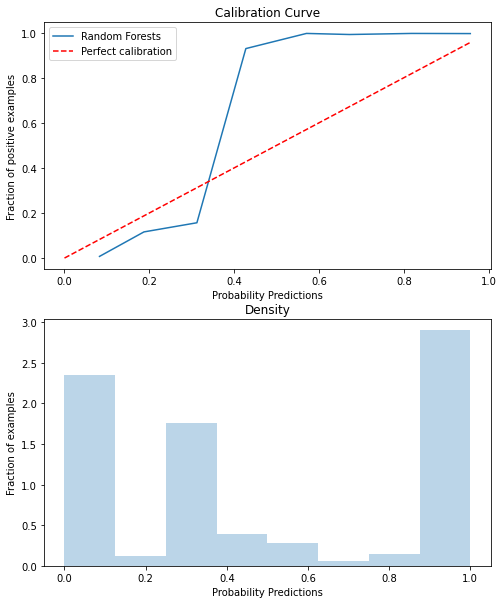

In [9]:
plot_calibration_curve(y_test, probs, bins=8, strategy='uniform')

The probability of the random forests is uncalibrated

## Probability Re-calibration

In [10]:
# Isotonic calibration
clf_isotonic = CalibratedClassifierCV(rf, cv=5, method='isotonic')
clf_isotonic.fit(X_test, y_test)
prob_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(rf, cv=5, method='sigmoid')
clf_sigmoid.fit(X_test, y_test)
prob_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

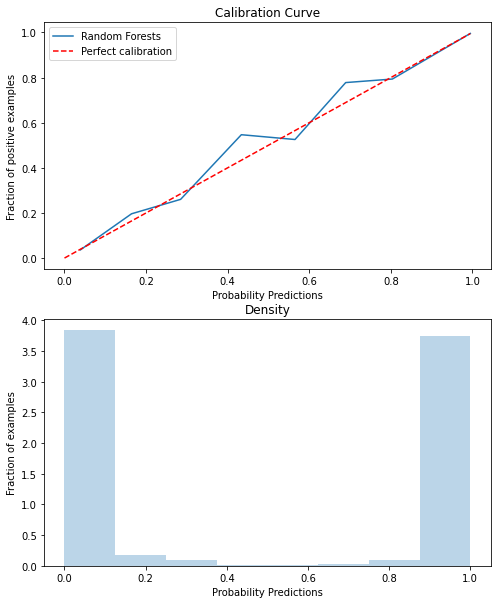

In [11]:
plot_calibration_curve(y_test, prob_isotonic, bins=8, strategy='uniform')

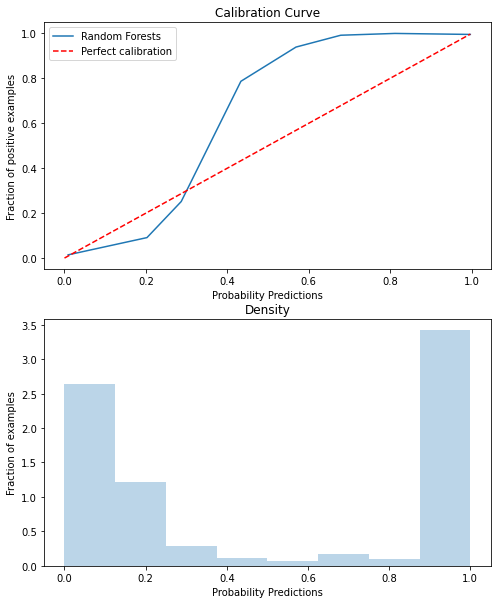

In [12]:
plot_calibration_curve(y_test, prob_sigmoid, bins=8, strategy='uniform')

The Isotonic Calibration worked better than Plat Scaling

**HOMEWORK**

- train and calibrate other machine learning models

- change the data set size, class separatibily, number of predictive and redundant features